In [1]:
import numpy as np
import pandas as pd
from tifffile import imread, imsave
import matplotlib.pyplot as plt
import glob
from scipy import ndimage as ndi
from skimage.filters import gaussian
import matplotlib.gridspec as gridspec
from math import cos, sin, pi
from scipy.interpolate import interp1d
from scipy.spatial import Delaunay
from skimage.morphology import dilation, watershed, disk, remove_small_objects
%matplotlib inline
from scipy.ndimage.interpolation import rotate
from scipy.interpolate import interp1d
from scipy.stats import skew, gamma, kurtosis, entropy
from skimage.feature import peak_local_max
from skimage.measure import perimeter
import matplotlib.patches as patches
from scipy.ndimage.morphology import binary_dilation
import sys
sys.path.append('lib')
from segment import *
%load_ext autoreload
%autoreload 2
from pysal.explore.pointpats import PointPattern
from skimage.feature import greycomatrix, greycoprops

C:\Users\hpeter\Anaconda3\lib\site-packages\pysal\explore\segregation\network\network.py:16: UserWarning: You need pandana and urbanaccess to work with segregation's network module
You can install them with  `pip install urbanaccess pandana` or `conda install -c udst pandana urbanaccess`
  "You need pandana and urbanaccess to work with segregation's network module\n"
C:\Users\hpeter\Anaconda3\lib\site-packages\pysal\model\spvcm\abstracts.py:10: UserWarning: The `dill` module is required to use the sqlite backend fully.
  from .sqlite import head_to_sql, start_sql


In [2]:
plt.rcParams['font.size']=14

In [3]:
l_files=glob.glob("../final_images/*.tif")
l_files.sort()


In [ ]:
#prepare stacks of time series
plexi=54
filt_size=5
size=(40,40,2.18)
thr_valleys_low=100
thr_valleys_high=222
im_list=[]
for path in l_files[-2:-1]: 
    print(path)
    tic()
    i=imread(path)[10:-10,10:-10]
    i=ndi.median_filter(i, size=filt_size)
    i=i-plexi
    i[i<0]=0  
    im_list.append(i)

In [ ]:
Z=np.zeros((min([i.shape[0] for i in im_list]),min([i.shape[1] for i in im_list]),6))
x=0
for i in im_list:
    Z[:,:,x]=im_list[x][:Z.shape[0],:Z.shape[1]]
    x=x+1

In [ ]:
# imsave("../DEMs/LR_Stack_Gradient_RepI.tif",Z)

In [5]:
l_files=['../DEMs\\LR_Stack_Gradient_RepI.tif', '../DEMs\\LR_Stack_Gradient_RepII.tif']

In [14]:
cols=['x','path','time','vol','growth','max_height','cov','compact','q02','q08','a50','a100','a500','a590','a1090','a5090']
data=pd.DataFrame(columns=cols)
step=100;w=600;
size=(10/250,10/250,2.18/1000)
for path in l_files: 
    i=imread(path)
    print(path)
    windows_list=[]
    lag_list=[]
    for lag in np.arange(0,w,step):
        windows_list.extend(np.split(i,np.arange(lag,i.shape[1],w),axis=1)[1:-1])
        lag_list.extend(np.arange(lag,i.shape[1],w)[:-1])
    for j in range(len(windows_list)):
        im=windows_list[j]
        for t in [5]:#range(im.shape[2]):
            patch=im[:,:,t]
            vol=np.sum(patch)*size[0]*size[1]*size[2]
            hei=np.nanquantile(patch,.95)*size[2]
            q02=np.nanquantile(patch,.2)*size[2]
            q08=np.nanquantile(patch,.8)*size[2]
            
            cov=np.sum(patch>0)/np.sum(np.invert(np.isnan(patch)))#(patch.shape[0]*patch.shape[1])
            if t==0:
                gr=0
                gr_rel=0
            else:
                gr=(vol-(np.sum(im[:,:,t-1])*size[0]*size[1]*size[2]))/3
            compact=vol/(hei*(patch.shape[0]*patch.shape[1])*(size[0]*size[1]))
            glcm = greycomatrix(patch.astype('uint32'), levels=np.max(patch.astype('uint32'))+1,distances=[5,10,50], angles=[0,90], 
                symmetric=True, normed=True)
            a50=greycoprops(glcm, 'correlation')[0, 0]
            a100=greycoprops(glcm, 'correlation')[1, 0]
            a500=greycoprops(glcm, 'correlation')[2, 0]
            a590=greycoprops(glcm, 'correlation')[0, 1]
            a1090=greycoprops(glcm, 'correlation')[1, 1]
            a5090=greycoprops(glcm, 'correlation')[2, 1]
            data=data.append(pd.DataFrame([[lag_list[j]*size[0]/1000,path,t,vol,gr,hei,cov*100,compact,
                                            q02,q08,a50,a100,a500,a590,a1090,a5090]],columns=cols)) 

data=data.sort_values(by='x')
data['porosity']=1-data.compact
data['growth_rel']=(data.vol+data.growth)/data.vol

../DEMs\LR_Stack_Gradient_RepI.tif
../DEMs\LR_Stack_Gradient_RepII.tif


In [15]:
#ADD SPEED BASED ON SIMULATION (FIGURE 1 A)
z=np.array([ 0.22576732, -0.32349831,  0.16948871])
f=np.poly1d(z)
Q=2.22e-4 #m3/s
H=2.22e-2 #m
data['speed']=Q/(H*f(data['x']))
data['rep']=[i.split('Rep')[1][:-4] for i in data['path']]

In [16]:
vsl=pd.read_csv('../data-tables/VSL_thickness.csv')
vsl=vsl.sort_values(by='y')
data.growth_rel=1+((data.growth_rel*3-1))

In [45]:
data.to_csv('../Tables/morphological_gradients.csv')

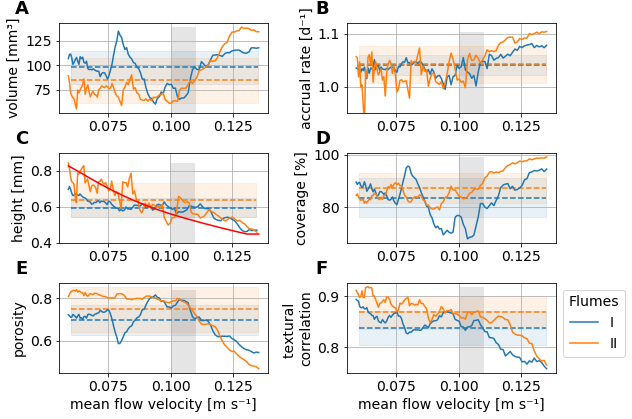

In [56]:
var=['vol','growth_rel','max_height','cov', 'porosity','a50']
labels=['volume [mm³]','accrual rate [d⁻¹]','height [mm]','coverage [%]','porosity','textural \ncorrelation']

t=5
d=data[data['time']==t]

fig,ax=plt.subplots(nrows=3, ncols=2, figsize=(9,6))
ax=ax.ravel()
x=np.linspace(0.06,0.135,2)
for a in range(len(var)):
#     for r in ['I','II','III']:
    irep=0
    for r in ['I','II','']:
        dd=d[d['rep']==r]
        dd=dd.sort_values(by='speed')
        ax[a].grid()
        ax[a].plot(dd['speed'],dd[var[a]], label=r, color=plt.cm.tab10(irep))
        ax[a].hlines(y=np.mean(dd[var[a]]), xmin=0.06, xmax=0.135, color=plt.cm.tab10(irep), linestyle='dashed')
        ax[a].fill_between(x, (np.mean(dd[var[a]])-np.std(dd[var[a]])), (np.mean(dd[var[a]])+np.std(dd[var[a]])), color=plt.cm.tab10(irep), alpha=.1)
#         ax[a].set_xlim(0.85,0.42)
        ax[a].set_ylabel(labels[a])
        
        irep=irep+1
    rect = patches.Rectangle((.10,0),0.01,max(d[var[a]]),linewidth=0,facecolor='black',alpha=.1)
    ax[a].add_patch(rect)
    #     ax[a].axvline(x=4.25, ymin=0, ymax=max(d[var[a]]), linestyle='--', color='gray')
ax[2].plot(vsl['speed'],vsl['vsl'], color='red', label='VSL thickness')
# ax[4].plot(vsl['speed'],vsl['vsl'], color='red')
# ax[-1].set_yscale('log')
ax[1].set_ylim(0.95,1.12)
ax[2].set_ylim(0.4,.9)

ax[-2].set_xlabel('mean flow velocity [m s⁻¹]')
ax[-1].set_xlabel('mean flow velocity [m s⁻¹]')
plt.legend(bbox_to_anchor=(1, 1), title='Flumes')
plt.tight_layout()
bbox = ax[0].get_tightbbox(fig.canvas.get_renderer())
labs=['A','C','E']
labs1=['B','D','F']

for i in range(3):
    fig.text(bbox.x0,bbox.y1+10-(i*130), labs[i], fontsize=18,fontweight="bold", va="top", ha="left",transform=None)
    fig.text(bbox.x0+300,bbox.y1+10-(i*130), labs1[i], fontsize=18, fontweight="bold", va="top", ha="left",transform=None)

#fig.savefig('../plots-figures/FinalFigures/Fig2/Fig2_reduced.svg',transparent=True,dpi=300)


In [78]:
table1=data[data.x.isin([0,0.416])][var+['speed','rep']]
table1.vol=round(table1.vol)
table1['cov']=round(table1['cov'])
table1.growth_rel=round(table1.growth_rel,2)
table1.max_height=round(table1.max_height,2)
table1.porosity=round(table1.porosity,2)
table1.speed=round(table1.speed,3)
table1.a50=round(table1.a50,2)

table1.columns=['volume [mm³]','accrual rate [d⁻¹]','height [mm]','coverage [%]','porosity','textural correlation','speed [m s⁻¹]','flume']

In [79]:
table1=table1[[table1.columns.to_list()[i] for i in [6,7,0,1,2,3,4,5]]]

In [82]:
table1

speed [m s⁻¹] flume  volume [mm³]  accrual rate [d⁻¹]  height [mm]  \
0          0.059     I         107.0                1.03         0.70   
0          0.059    II          89.0                1.06         0.84   
0          0.135     I         118.0                1.08         0.47   
0          0.135    II         134.0                1.10         0.46   

   coverage [%]  porosity  textural correlation  
0          90.0      0.72                  0.89  
0          85.0      0.81                  0.91  
0          95.0      0.54                  0.76  
0          99.0      0.47                  0.76

In [81]:
table1.to_csv('../Tables\Table1.csv',index=False)

In [86]:
(1.08-1.03)*100/1.03,(1.1-1.06)*100/1.06

(4.854368932038839, 3.7735849056603805)

SUPPLEMENTARY FIGURE 2

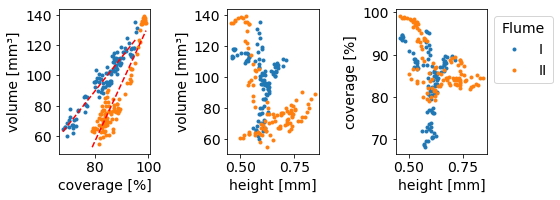

In [92]:
t=5
d=data[data['time']==t]

fig,ax=plt.subplots(nrows=1, ncols=3, figsize=(8,3))
ax=ax.ravel()
Rsq=pd.DataFrame(columns=['rep','slope coverage','R-sq coverage','slope height','R-sq height'])

for r in ['I','II']:
    dd=d[d['rep']==r]
    dd=dd.sort_values(by='cov')
    y=dd['vol']
    x=dd['cov']
    coefc = np.polyfit(x,y,1)
    poly1d_fn = np.poly1d(coefc) 
    correlationc = np.corrcoef(x, y)[0,1]
    ax[0].plot(x,y, '.', x, poly1d_fn(x), '--r', label=r)

#     ax[0].plot(dd['cov'],dd['vol'],'.', label=r)
#         ax[a].set_xlim(0.85,0.42)
    ax[0].set_ylabel('volume [mm³]')
    ax[0].set_xlabel('coverage [%]')
    ax[0].grid()
#    dd=dd.sort_values(by='max_height')
    x=dd['max_height']
    coef = np.polyfit(x,y,1)
    poly1d_fn = np.poly1d(coef) 
    correlation = np.corrcoef(x, y)[0,1]

    ax[1].plot(x,y, '.', label=r)
    
#     ax[1].plot(dd['max_height'],dd['vol'],'.', label=r)
#         ax[a].set_xlim(0.85,0.42)
    ax[1].set_ylabel('volume [mm³]')
    ax[1].set_xlabel('height [mm]')
    ax[1].grid()
    
    Rsq=Rsq.append(pd.DataFrame([[r,coefc[0],correlationc,coef[0],correlation]],columns=['rep','slope coverage','R-sq coverage','slope height','R-sq height']))
    #     ax[a].axvline(x=4.25, ymin=0, ymax=max(d[var[a]]), linestyle='--', color='gray')

    x=dd['max_height']
    y=dd['cov']
    coef = np.polyfit(x,y,1)
    poly1d_fn = np.poly1d(coef) 
    correlation = np.corrcoef(x, y)[0,1]

    ax[2].plot(x,y, '.', label=r)
    
#     ax[1].plot(dd['max_height'],dd['vol'],'.', label=r)
#         ax[a].set_xlim(0.85,0.42)
    ax[2].set_ylabel('coverage [%]')
    ax[2].set_xlabel('height [mm]')
    ax[2].grid()
    
# ax[-1].set_yscale('log')
plt.legend(bbox_to_anchor=(1, 1), title='Flume')
plt.tight_layout()
fig.savefig('../plots-figures/FinalFigures/SFigure2.svg', dpi=300)
fig.savefig('../plots-figures/FinalFigures/SFigure2.png', dpi=100)


In [89]:
Rsq

rep  slope coverage  R-sq coverage  slope height  R-sq height
0   I        2.232677       0.955742    -72.261907    -0.223433
0  II        3.817306       0.928662   -121.619581    -0.500961